In [1]:
import torch,gc
from torch import nn
from torchvision import transforms


import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
file_path = Path("mini_food/pizza_steak_sushi/")

train_dir = file_path/"train"
test_dir = file_path/"test"


In [4]:
image_transform = transforms.Compose(
    [
        transforms.Resize(size=(224,224)),
        transforms.ToTensor()
    ]
)

In [5]:
from data_setup import create_dataloaders


train_dataloader,test_dataloader,class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=image_transform,
    batch_size=32
)

2.6.0+cu124 True


In [6]:
class_names

['pizza', 'steak', 'sushi']

(-0.5, 223.5, 223.5, -0.5)

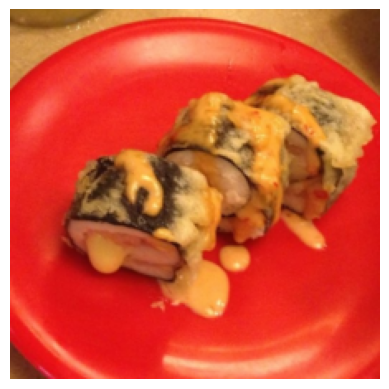

In [7]:
image_batch,label_batch = next(iter(train_dataloader))
test_image,test_label = image_batch[0],label_batch[0]

plt.imshow(test_image.permute(1,2,0))
plt.axis(False)

In [8]:
patch_size = 16
height = 224
width = 224
color_channels = 3

N = int((height*width)//patch_size**2)
N

196

In [9]:
img_size = 224
no_of_patches = img_size // patch_size
# k=1
# for i in range(no_of_patches):
#     for j in range(no_of_patches):
#         plt.subplot(no_of_patches,no_of_patches,k)
#         plt.imshow(test_image.permute(1,2,0)[i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size,:])
#         plt.axis(False)
#         k+=1

In [10]:
class Permute(nn.Module):
    def __init__(self,dim):
        super().__init__()
        self.dim = dim
    
    def forward(self,x):
        return x.permute(self.dim)
class PatchEmbedding(nn.Module):
    
    def __init__(self,in_channels,patch_size,embedding_dim):
        super().__init__()
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            padding=0,
            kernel_size=patch_size,
            stride=patch_size
        )
        
        self.flatten = nn.Sequential(nn.Flatten(
            start_dim=2,
            end_dim=3
            ),
                                     Permute((0,2,1)))
        
    def forward(self,x):
        print(f"x Shape Before Patched : {x.shape}")
        x_patched = self.patcher(x)
        print(f"x SHape After Patched: {x_patched.shape}")
        
        x_flattened = self.flatten(x_patched)
        print(f"x Shape After Flattened and Permuted: {x_flattened.shape}")
        
        return x_flattened
        

In [11]:
patcher = PatchEmbedding(in_channels=3,
                         patch_size=patch_size,
                         embedding_dim=768)

print(f"Input Image Size:{test_image.shape}")
patched_image = patcher(test_image.unsqueeze(0))
print(f"Ouput Image Size:{patched_image.shape}")

Input Image Size:torch.Size([3, 224, 224])
x Shape Before Patched : torch.Size([1, 3, 224, 224])
x SHape After Patched: torch.Size([1, 768, 14, 14])
x Shape After Flattened and Permuted: torch.Size([1, 196, 768])
Ouput Image Size:torch.Size([1, 196, 768])


In [12]:
batch_size = patched_image.shape[0]
embedding_dim = patched_image.shape[-1]
batch_size,embedding_dim

(1, 768)

In [13]:
class_token = nn.Parameter(
    torch.ones(batch_size,1,embedding_dim)
)
class_token.shape

torch.Size([1, 1, 768])

In [14]:
patched_image_with_class_token = torch.cat((class_token,patched_image),dim=1)
patched_image_with_class_token.shape

torch.Size([1, 197, 768])

In [15]:
position_embedding = nn.Parameter(torch.ones(
    batch_size,
    1+N,
    embedding_dim
))
position_embedding.shape

torch.Size([1, 197, 768])

In [16]:
patched_and_pos_embed = patched_image_with_class_token + position_embedding
patched_and_pos_embed,patched_and_pos_embed.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [1.0525, 0.7570, 1.0484,  ..., 1.0533, 0.6978, 1.1992],
          [1.0307, 0.7581, 1.0732,  ..., 1.0893, 0.6969, 1.1828],
          ...,
          [0.9364, 0.6164, 1.1270,  ..., 1.0347, 0.6555, 1.2771],
          [0.9545, 0.6142, 1.1513,  ..., 0.9927, 0.6840, 1.2786],
          [0.9300, 0.6557, 1.0415,  ..., 1.0178, 0.7459, 1.2353]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [17]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self,embedding_dim,num_heads,attn_dropout=0):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )
        
    
    def forward(self,x):
        x_lnorm = self.layer_norm(x)
        attn_out = self.multihead_attn(
            query = x_lnorm,
            key = x_lnorm,
            value = x_lnorm,
            need_weights = False
        )
    
        return attn_out
    


In [18]:
mha_block = MultiHeadAttentionBlock(embedding_dim=embedding_dim,
                                    num_heads=12,
                                    attn_dropout=0)

patched_and_pos_embed_attn_out,_ = mha_block(patched_and_pos_embed)
patched_and_pos_embed,patched_and_pos_embed_attn_out,patched_and_pos_embed.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [1.0525, 0.7570, 1.0484,  ..., 1.0533, 0.6978, 1.1992],
          [1.0307, 0.7581, 1.0732,  ..., 1.0893, 0.6969, 1.1828],
          ...,
          [0.9364, 0.6164, 1.1270,  ..., 1.0347, 0.6555, 1.2771],
          [0.9545, 0.6142, 1.1513,  ..., 0.9927, 0.6840, 1.2786],
          [0.9300, 0.6557, 1.0415,  ..., 1.0178, 0.7459, 1.2353]]],
        grad_fn=<AddBackward0>),
 tensor([[[-0.0152, -0.0766,  0.5305,  ...,  0.3836,  0.5016, -0.2140],
          [-0.0185, -0.0813,  0.5302,  ...,  0.3778,  0.4989, -0.2102],
          [-0.0188, -0.0819,  0.5301,  ...,  0.3784,  0.4987, -0.2090],
          ...,
          [-0.0209, -0.0826,  0.5307,  ...,  0.3793,  0.4994, -0.2060],
          [-0.0189, -0.0808,  0.5308,  ...,  0.3805,  0.4994, -0.2084],
          [-0.0193, -0.0814,  0.5308,  ...,  0.3807,  0.5014, -0.2074]]],
        grad_fn=<TransposeBackward0>),
 torch.Size([1, 197, 768]))

In [19]:
class MLPBlock(nn.Module):
    def __init__(self,embedding_dim,mlp_size,dropout=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(
                in_features=embedding_dim,
                out_features=mlp_size
            ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=mlp_size,
                out_features=embedding_dim
            ),
            nn.Dropout(p=dropout)
        )
        
    def forward(self,x):
        x_lnorm = self.layer_norm(x)
        
        x_mlp = self.mlp(x_lnorm)
        
        return x_mlp

In [20]:
patched_and_pos_embed_attn_out

tensor([[[-0.0152, -0.0766,  0.5305,  ...,  0.3836,  0.5016, -0.2140],
         [-0.0185, -0.0813,  0.5302,  ...,  0.3778,  0.4989, -0.2102],
         [-0.0188, -0.0819,  0.5301,  ...,  0.3784,  0.4987, -0.2090],
         ...,
         [-0.0209, -0.0826,  0.5307,  ...,  0.3793,  0.4994, -0.2060],
         [-0.0189, -0.0808,  0.5308,  ...,  0.3805,  0.4994, -0.2084],
         [-0.0193, -0.0814,  0.5308,  ...,  0.3807,  0.5014, -0.2074]]],
       grad_fn=<TransposeBackward0>)

In [21]:
mlp_block = MLPBlock(
    embedding_dim=embedding_dim,
    mlp_size=3072,
    dropout=0.1
)

patched_and_pos_embed_attn_out_and_mlp_out = mlp_block(patched_and_pos_embed_attn_out)
patched_and_pos_embed_attn_out_and_mlp_out,patched_and_pos_embed_attn_out_and_mlp_out.shape

(tensor([[[ 0.1282,  0.0653, -0.3753,  ...,  0.1256,  0.2914,  0.2154],
          [ 0.0766,  0.0851, -0.2846,  ...,  0.0798,  0.2387,  0.2634],
          [ 0.1062,  0.0473, -0.4281,  ...,  0.0000,  0.3032,  0.0000],
          ...,
          [ 0.0825,  0.0602, -0.2260,  ...,  0.0000,  0.3651,  0.2812],
          [ 0.1038, -0.0031, -0.3174,  ...,  0.0254,  0.2531,  0.2977],
          [ 0.0056,  0.1162, -0.3140,  ...,  0.1558,  0.2800,  0.3022]]],
        grad_fn=<MulBackward0>),
 torch.Size([1, 197, 768]))

In [22]:
transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
)

from torchinfo import summary

summary(model=transformer_encoder_layer,input_size=(1,197,768),col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 2048]       1,574,912            True
├─Dropout (dropout)                                [1, 197, 2048]       [1, 197, 2048]       --                   --
├─Linear (linear2)                             

In [23]:
#my understannding (without transformer stacking)
class Permute(nn.Module):
    def __init__(self,dim):
        super().__init__()
        self.dim = dim
    
    def forward(self,x):
        return x.permute(self.dim)
    
    
class MyViT(nn.Module):
    def __init__(self,in_channels,patch_size,N,embedding_dim,num_heads,mlp_size,attn_dropout=0.1,dropout=0.1,num_classes=1000):
        super().__init__()
        self.N = N
        self.patcher = nn.Sequential(
            nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            padding=0,
            kernel_size=patch_size,
            stride=patch_size
        )
            ,nn.Flatten(start_dim=2,
                        end_dim=3),
            Permute((0,2,1)))
        
        
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )
        
        self.mlp = nn.Sequential(
            nn.Linear(
                in_features=embedding_dim,
                out_features=mlp_size
            ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=mlp_size,
                out_features=embedding_dim
            ),
            nn.Dropout(p=dropout)
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(
                in_features=embedding_dim,
                out_features=num_classes
            )
        )
    
    def forward(self,x):
        print(f"x Shape Before Patched: {x.shape}")
        x_patched = self.patcher(x)
        print(f"x Shape After Patched, Flattened and Permuted: {x_patched.shape}")
        
        class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dim))
        
        position_embedding = nn.Parameter(torch.ones(batch_size,1+self.N,embedding_dim))
        
        x_patched_and_pos_embed = torch.cat((class_token,x_patched),dim=1) + position_embedding
        
        print(f"x Shape After Patched, Class Token and Position Embedding: {x_patched_and_pos_embed.shape}")
        x_lnorm = self.layer_norm(x_patched_and_pos_embed)
        
        x_attn_out,_ = self.multihead_attn(
            query = x_lnorm,
            key = x_lnorm,
            value = x_lnorm,
            need_weights = False
        )
        print(f"x Shape After Attendtion Output: {x_attn_out.shape}")
        x_attn_out = x_attn_out + x_patched_and_pos_embed
        
        x_lnorm = self.layer_norm(x_attn_out)
        
        x_mlp = self.mlp(x_lnorm)
        
        print(f"x Shape After MLP: {x_mlp.shape}")
        
        x_mlp = x_mlp + x_attn_out
        
        y = self.classifier(x_mlp)
        print(f"Final Shape (y): {y.shape}")
        
        return y

In [24]:

model = MyViT(in_channels=3,patch_size=patch_size,N=N,embedding_dim=embedding_dim,num_heads=12,mlp_size=3072,num_classes=3)

out = model(test_image.unsqueeze(0))
out.shape

x Shape Before Patched: torch.Size([1, 3, 224, 224])
x Shape After Patched, Flattened and Permuted: torch.Size([1, 196, 768])
x Shape After Patched, Class Token and Position Embedding: torch.Size([1, 197, 768])
x Shape After Attendtion Output: torch.Size([1, 197, 768])
x Shape After MLP: torch.Size([1, 197, 768])
Final Shape (y): torch.Size([1, 197, 3])


torch.Size([1, 197, 3])

In [25]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,embedding_dim,num_heads,mlp_size,mlp_dropout,attn_dropout):
        super().__init__()
        
        self.msa_block = MultiHeadAttentionBlock(embedding_dim=embedding_dim,num_heads=num_heads,attn_dropout=attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,mlp_size=mlp_size,dropout=mlp_dropout)
        
    def forward(self,x):
        
        x = self.msa_block(x) + x
        
        x = self.mlp_block(x) + x
        
        return x

In [26]:
transformer_encoder_block = TransformerEncoderBlock(embedding_dim=embedding_dim,num_heads=12,mlp_size=3072,mlp_dropout=0.1,attn_dropout=0.1)

In [27]:
class Permute(nn.Module):
    def __init__(self,dim):
        super().__init__()
        self.dim = dim
    
    def forward(self,x):
        return x.permute(self.dim)
class PatchEmbedding(nn.Module):
    
    def __init__(self,in_channels,patch_size,embedding_dim):
        super().__init__()
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            padding=0,
            kernel_size=patch_size,
            stride=patch_size
        )
        
        self.flatten = nn.Sequential(nn.Flatten(
            start_dim=2,
            end_dim=3
            ),
                                     Permute((0,2,1)))
        
    def forward(self,x):
        # print(f"x Shape Before Patched : {x.shape}")
        x_patched = self.patcher(x)
        # print(f"x SHape After Patched: {x_patched.shape}")
        
        x_flattened = self.flatten(x_patched)
        # print(f"x Shape After Flattened and Permuted: {x_flattened.shape}")
        
        return x_flattened
        
    
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self,embedding_dim,num_heads,attn_dropout=0):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )
        
    
    def forward(self,x):
        x_lnorm = self.layer_norm(x)
        attn_out,_ = self.multihead_attn(
            query = x_lnorm,
            key = x_lnorm,
            value = x_lnorm,
            need_weights = False
        )
    
        return attn_out

class MLPBlock(nn.Module):
    def __init__(self,embedding_dim,mlp_size,dropout=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(
                in_features=embedding_dim,
                out_features=mlp_size
            ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=mlp_size,
                out_features=embedding_dim
            ),
            nn.Dropout(p=dropout)
        )
        
    def forward(self,x):
        x_lnorm = self.layer_norm(x)
        
        x_mlp = self.mlp(x_lnorm)
        
        return x_mlp

class TransformerEncoderBlock(nn.Module):
    def __init__(self,embedding_dim,num_heads,mlp_size,mlp_dropout=0.1,attn_dropout=0.1):
        super().__init__()
        
        self.msa_block = MultiHeadAttentionBlock(embedding_dim=embedding_dim,num_heads=num_heads,attn_dropout=attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,mlp_size=mlp_size,dropout=mlp_dropout)
        
    def forward(self,x):
        
        x = self.msa_block(x) + x
        
        x = self.mlp_block(x) + x
        
        return x

class ViT(nn.Module):
    def __init__(self,image_size,in_channels,patch_size,num_layers,embedding_dim,num_heads,mlp_size,attn_dropout=0.1,embedding_dropout=0.1,num_classes=1000):
        super().__init__()
        self.no_of_patches = (image_size * img_size) // patch_size**2
        
        self.class_embedding = nn.Parameter(torch.ones(1,1,embedding_dim))
        
        self.position_embedding = nn.Parameter(torch.ones(batch_size,1+self.no_of_patches,embedding_dim))
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)        
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                attn_dropout=attn_dropout
            ) for _ in range(num_layers)]
        )
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(
                in_features=embedding_dim,
                out_features=num_classes
            )
        )        
        
        
    def forward(self,x):
        batch_size = x.shape[0]
        # print(f"Input shape: {x.shape}")
        
        class_token = self.class_embedding.expand(batch_size,-1,-1)
        # print(f"Class token shape: {class_token.shape}")
        
        x = self.patch_embedding(x)
        # print(f"After patch embedding shape: {x.shape}")
        
        x = torch.cat((class_token,x),dim = 1)
        # print(f"After adding class token shape: {x.shape}")
        
        x = x + self.position_embedding
        # print(f"After position embedding shape: {x.shape}")
        
        x = x + self.embedding_dropout(x)
        # print(f"After embedding dropout shape: {x.shape}")
        
        x = x + self.transformer_encoder(x)
        # print(f"After transformer encoder shape: {x.shape}")
        
        y = self.classifier(x[:, 0])
        # print(f"Final output shape: {y.shape}")
        
        return y

(-0.5, 223.5, 223.5, -0.5)

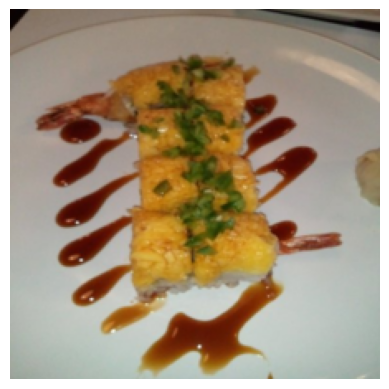

In [28]:
image_batch,label_batch = next(iter(train_dataloader))
test_image,test_label = image_batch[0],label_batch[0]

plt.imshow(test_image.permute(1,2,0))
plt.axis(False)

In [29]:
vit = ViT(image_size=224,
          in_channels=3,
          patch_size=16,
          num_layers=12,
          embedding_dim=768,
          num_heads=12,
          mlp_size=3072,num_classes=3)
out = vit(test_image.unsqueeze(0))
out,class_names[out.argmax()]

(tensor([[-0.1895,  0.3227,  0.8041]], grad_fn=<AddmmBackward0>), 'sushi')

In [30]:
from torchinfo import summary

summary(model=vit,input_size=test_image.unsqueeze(0).shape,col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Sequential (flatten)                                  [1, 768, 14, 14]     [1, 196, 768]        --                   --
│    │    └─Flatten (0)                                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
│    │    └─Permute (1)                                      [1, 768, 196]        [1, 196, 768]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]   

In [31]:
from engine import train

optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr = 3e-3,
    betas=(0.9,0.999),
    weight_decay=0.3
)

loss_fn = nn.CrossEntropyLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
results = train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device,writer=None)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.0696 | train_acc: 30.0781 | test_loss: 1.0682 | test_acc: 54.1667
Epoch: 2 | train_loss: 1.5593 | train_acc: 41.4062 | test_loss: 2.5724 | test_acc: 26.0417
Epoch: 3 | train_loss: 1.2074 | train_acc: 28.1250 | test_loss: 6.1798 | test_acc: 26.0417
Epoch: 4 | train_loss: 1.2046 | train_acc: 28.9062 | test_loss: 5.0573 | test_acc: 19.7917
Epoch: 5 | train_loss: 1.1045 | train_acc: 41.0156 | test_loss: 5.5403 | test_acc: 26.0417
Epoch: 6 | train_loss: 1.1047 | train_acc: 39.0625 | test_loss: 5.0965 | test_acc: 19.7917
Epoch: 7 | train_loss: 1.1380 | train_acc: 28.9062 | test_loss: 6.9587 | test_acc: 19.7917
Epoch: 8 | train_loss: 1.1362 | train_acc: 26.1719 | test_loss: 6.3784 | test_acc: 26.0417
Epoch: 9 | train_loss: 1.1442 | train_acc: 42.1875 | test_loss: 2.6849 | test_acc: 54.1667
Epoch: 10 | train_loss: 1.2370 | train_acc: 24.6094 | test_loss: 2.1271 | test_acc: 26.0417


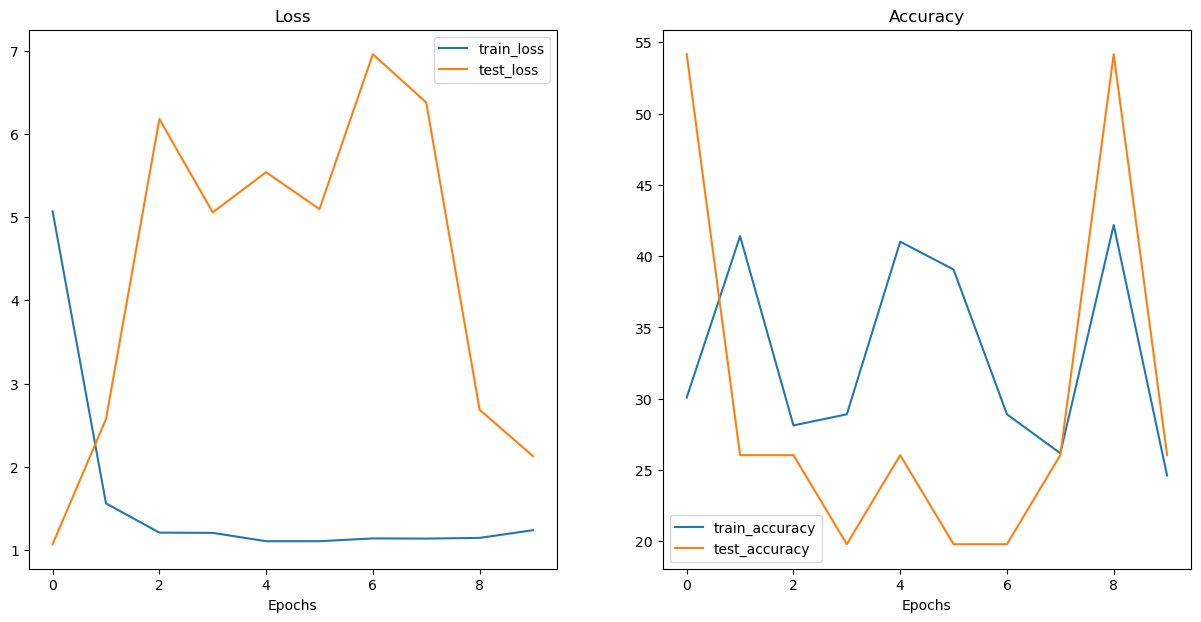

In [34]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)